In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import heartpy as hp

# HR Calculation

In [2]:
path = "data/ASCERTAIN"
ecg = loadmat(path + '/ECGData/Movie_P10/ECG_Clip10.mat')

right1 = ecg['Data_ECG'][:,4]
left1 = ecg['Data_ECG'][:,5]
time1 = ecg['Data_ECG'][:,0]
totalTime1 = ecg['Data_ECG'][:,0]

# left1 = left1/100
# right1 = right1/100

ecg.keys()

dict_keys(['__header__', '__version__', '__globals__', 'timeECG', 'Data_ECG', 'A_ECG', 'G_ECG', 'V_ECG'])

In [3]:
path = "data/ASCERTAIN"
ecg = loadmat(path + '/ECGData/Movie_P01/ECG_Clip1.mat')

ecg.keys()

dict_keys(['__header__', '__version__', '__globals__', 'timeECG', 'Data_ECG', 'A_ECG', 'G_ECG', 'V_ECG'])

In [4]:
interval = 5000

time2 = ecg['Data_ECG'][:,0]
totalTime2 = ecg['Data_ECG'][:,0]
right2 = ecg['Data_ECG'][:,1]
left2 = ecg['Data_ECG'][:,2]

# left2 = left2/100
# right2 = right2/100

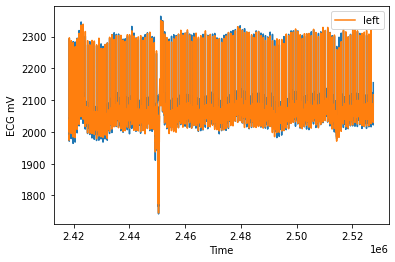

In [5]:
plt.plot(time2, right2)
plt.plot(time2, left2, label='left')
plt.legend()
plt.xlabel("Time")
plt.ylabel("ECG mV")
time2 = time2/1000

In [6]:
df1= pd.DataFrame({'hart' : left1})
df2 = pd.DataFrame({'hart' : left2})

In [7]:
df1['hart'].shape

(24783,)

In [8]:
def doIt(dataset):
#Calculate moving average with 0.75s in both directions, then append do dataset
    hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
    fs = 256 #The example dataset was recorded at 100Hz
    
    numValues = int(len(dataset)*0.05)
    
    peakAvg = dataset['hart'].nlargest(numValues).mean()
    avg = dataset['hart'].mean()
    
    raiseVal = peakAvg/avg
    print(raiseVal)

    mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean() #Calculate moving average
    #Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
    avg_hr = (np.mean(dataset.hart))
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    mov_avg = [x*raiseVal for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
    dataset['hart_rollingmean'] = mov_avg #Append the moving average to the dataframe

    #Mark regions of interest
    window = []
    peaklist = []
    listpos = 0 #We use a counter to move over the different data columns

    for datapoint in dataset.hart:
        rollingmean = dataset.hart_rollingmean[listpos] #Get local mean
        if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
            listpos += 1
        elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
            window.append(datapoint)
            listpos += 1
        else: #If signal drops below local mean -> determine highest point
            maximum = max(window)
            beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
            peaklist.append(beatposition) #Add detected peak to list
            window = [] #Clear marked ROI
            listpos += 1

    ybeat = [dataset.hart[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

    plt.title("Detected peaks in signal")
    plt.plot(dataset.hart, alpha=0.5, color='blue') #Plot semi-transparent HR
    plt.plot(mov_avg, color ='green') #Plot moving average
    plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
    plt.show()
    
    RR_list = []
    cnt = 0

    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
        ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
        RR_list.append(ms_dist) #Append to list
        cnt += 1

    bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
    print("Average Heart Beat is: %.01f" %bpm) #Round off to 1 decimal and print
    
    return peaklist

1.0240243232340351


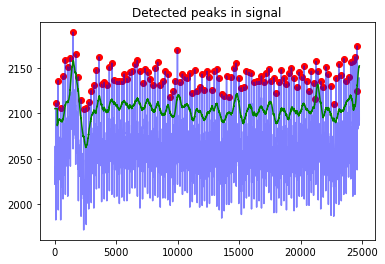

Average Heart Beat is: 77.0


124

In [9]:
len(doIt(df1))

1.0654268894629138


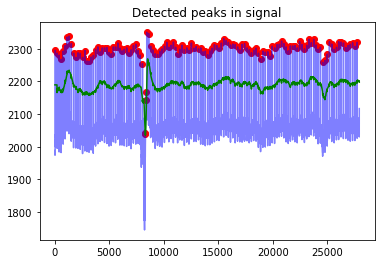

Average Heart Beat is: 75.9


138

In [10]:
len(doIt(df2))

In [27]:
def calculateBPM(seriesIn, colName):
#Calculate moving average with 0.75s in both directions, then append to dataset
    print('\n' + colName)
    hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
    fs = 256 #The example dataset was recorded at 256Hz
    
    series = seriesIn.copy()
    dropIdx = len(series.dropna())
    series = series.truncate(after=dropIdx)

    minuteHz = 15360
    currIdx = 15360
    bpmList = []
    
    while currIdx < len(series):
#         print(currIdx)
        currSlice = pd.DataFrame({colName : list(series.iloc[currIdx-minuteHz:currIdx])})
        currIdx += 256
    
        numValues = int(len(currSlice)*0.05)

        peakAvg = currSlice[colName].nlargest(numValues).mean()
        avg = currSlice[colName].mean()

        raiseVal = peakAvg/avg

        mov_avg = currSlice[colName].rolling(int(hrw*fs)).mean() #Calculate moving average
        #Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
        avg_hr = (np.mean(currSlice[colName]))
        mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
        mov_avg = [x*raiseVal for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
        currSlice['rollingmean'] = mov_avg #Append the moving average to the dataframe

        #Mark regions of interest
        window = []
        peaklist = []
        listpos = 0 #We use a counter to move over the different data columns

        for datapoint in currSlice[colName]:
            rollingmean = currSlice.rollingmean[listpos] #Get local mean
            if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
                listpos += 1
            elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
                window.append(datapoint)
                listpos += 1
            else: #If signal drops below local mean -> determine highest point
                maximum = max(window)
                beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
                peaklist.append(beatposition) #Add detected peak to list
                window = [] #Clear marked ROI
                listpos += 1

        ybeat = [currSlice[colName][x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

#         plt.title("Detected peaks in signal")
#         plt.plot(currSlice[colName], alpha=0.5, color='blue') #Plot semi-transparent HR
#         plt.plot(mov_avg, color ='green') #Plot moving average
#         plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
#         plt.show()

        RR_list = []
        cnt = 0
#         print(peaklist[-1])

        while (cnt < (len(peaklist)-1)):
            RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
            ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
            RR_list.append(ms_dist) #Append to list
            cnt += 1
            
#         if(str(np.mean(RR_list)) != 'nan'):
        bpm = round(60000 / np.mean(RR_list)) #60000 ms (1 minute) / average R-R interval of signal
        bpmList.append(bpm)
    #     print("Average Heart Beat is: %.01f" %bpm) #Round off to 1 decimal and print

    return bpmList

In [28]:
calculateBPM(df1['hart'], 'hart')


hart


[75,
 75,
 75,
 75,
 76,
 89,
 99,
 86,
 87,
 88,
 88,
 88,
 89,
 90,
 89,
 90,
 91,
 91,
 91,
 91,
 91,
 91,
 91,
 88,
 86,
 85,
 84,
 85,
 85,
 86,
 84,
 84,
 84,
 83,
 83,
 82,
 82]

In [30]:
calculateBPM(df2['hart'], 'hart')


hart


[76,
 77,
 77,
 78,
 77,
 77,
 78,
 78,
 77,
 76,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 77,
 76,
 76,
 77,
 77,
 77,
 77,
 77,
 76,
 76,
 75,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73,
 73]